## LSTM-Stacked model 


                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

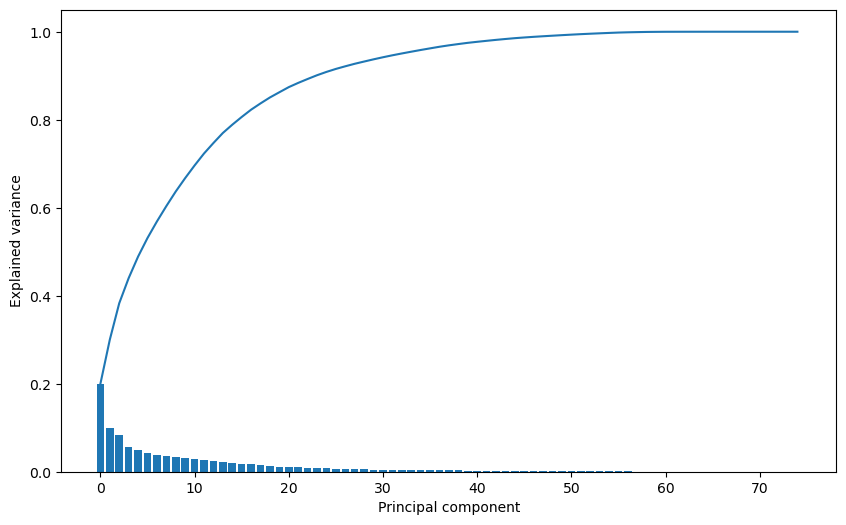

In [2]:
# Standard libraries
import random
import numpy as np
import pandas as pd
import pickle

# Visualization
import matplotlib.pyplot as plt

# Evaluation metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# TensorFlow / Keras – model architecture, training, loading
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN

# Hyperparameter tuning
import keras_tuner as kt

# Local modules and notebook imports
import import_ipynb
from feature_engineering import scaler_y

In [3]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)


In [4]:
#Seed for reproducibility

SEED  = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


In [5]:
batch_size = 32  # consistent batch size for fair comparison

# Create TensorFlow Dataset from training data, including shuffle for better generalization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=len(X_train), seed= SEED) \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from validation data (no shuffle needed, cache for performance)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from test data (no shuffle needed, cache for performance)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

In [6]:
for X_batch, y_batch in train_dataset.take(1):
    print(f"Batch shape (X, y): {X_batch.shape}, {y_batch.shape}")

Batch shape (X, y): (32, 24, 17), (32,)


2025-03-26 15:10:23.686164: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    #train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    #plt.figure(figsize=(20, 10))
    #plt.subplot(1, 2, 1)
    #plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    #plt.legend()
    #plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [8]:
# Function to build stacked LSTM model with hyperparameters
def build_stacked_lstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Separate input shape definition to avoid Keras warning

    # First LSTM layer with return_sequences=True for stacked LSTM
    model.add(LSTM(
        units=hp.Int('stacked_lstm_units_1', min_value=16, max_value=256, step=16),
        return_sequences=True  # Required to pass sequences to the next LSTM layer
    ))
    # Dropout layer for the first LSTM layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_lstm_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    ))

    # Second LSTM layer with return_sequences=False
    model.add(LSTM(
        units=hp.Int('stacked_lstm_units_2', min_value=16, max_value=256, step=16),
        return_sequences=False  # No sequences needed for the Dense layer
    ))
    # Dropout layer for the second LSTM layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_lstm_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    ))

    # Second hidden layer (Dense layer)
    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu'
    ))
    # Dropout layer for the Dense layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_dense', [0.0, 0.1, 0.2, 0.3, 0.4])
    ))

    # Output layer
    model.add(Dense(1))

    # Adam Optimizer with global weight decay
    optimizer = tf.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]),
        weight_decay=hp.Choice('weight_decay', [1e-5, 1e-4, 1e-3])
    )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Keras Tuner for stacked LSTM
tuner = kt.Hyperband(
    build_stacked_lstm_model,  # Model-building function
    objective='val_loss',  # Objective: minimize validation loss
    max_epochs=20,  # Maximum number of epochs per trial
    factor=3,  # Each successive round reduces the number of trials by this factor
    hyperband_iterations=1,  # Number of Hyperband iterations
    distribution_strategy=tf.distribute.MirroredStrategy(),  # Use all available GPUs
    directory='keras_tuner_stacked_lstm',  # Directory for storing tuner results
    project_name='stacked_lstm_hyperband',  # Project name
    seed=SEED
)

# Execute tuning
tuner.search(train_dataset, epochs=10, validation_data=val_dataset)

Trial 30 Complete [00h 07m 10s]
val_loss: 0.0015803917776793242

Best val_loss So Far: 0.0004886565147899091
Total elapsed time: 02h 01m 32s


In [9]:
# Collect best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM units layer 1: {best_hps.get('stacked_lstm_units_1')}")
print(f"Best LSTM units layer 2: {best_hps.get('stacked_lstm_units_2')}")
print(f"Best dense layer units: {best_hps.get('dense_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate (LSTM layer 1): {best_hps.get('dropout_rate_lstm_1')}")
print(f"Best dropout rate (LSTM layer 2): {best_hps.get('dropout_rate_lstm_2')}")
print(f"Best dropout rate (dense): {best_hps.get('dropout_rate_dense')}")
print(f"Best Global weight decay: {best_hps.get('weight_decay')}")

# Train best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("saved_models/stacked_lstm_best.keras", monitor="val_loss", save_best_only=True)
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, epochs=50, validation_data=val_dataset, verbose=1, callbacks=[early_stopping, model_checkpoint])

Best LSTM units layer 1: 176
Best LSTM units layer 2: 112
Best dense layer units: 64
Best learning rate: 0.001
Best dropout rate (LSTM layer 1): 0.1
Best dropout rate (LSTM layer 2): 0.2
Best dropout rate (dense): 0.1
Best Global weight decay: 1e-05
Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 8.5957e-04 - val_mse: 8.5957e-04
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 7.8132e-04 - val_mse: 7.8132e-04
Epoch 7/50
845

In [10]:
print(X_train.shape)

(27024, 24, 17)


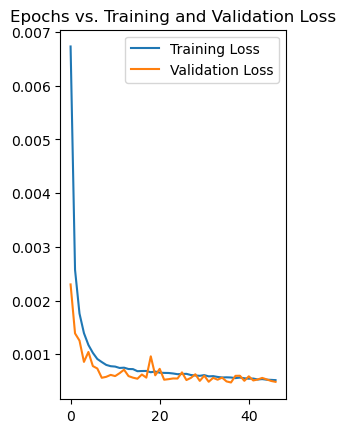

In [11]:
plot_model_rmse_and_loss(history)

In [12]:

stacked_lstm_model_best = load_model("saved_models/stacked_lstm_best.keras")
predictions = stacked_lstm_model_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE (Stacked LSTM): {rmse:.4f}')

  4/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step  

2025-03-26 17:53:20.909554: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-26 17:53:20.909902: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
RMSE (Stacked LSTM): 0.0211


 10/845 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step

2025-03-26 17:53:31.274024: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-26 17:53:31.275009: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

845/845 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step
 10/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

2025-03-26 17:53:47.023924: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-03-26 17:53:47.024261: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


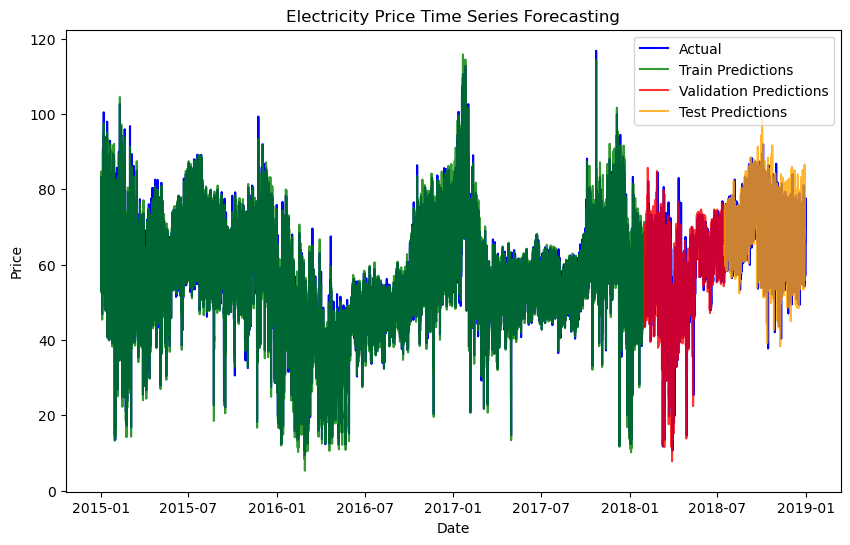

In [13]:
# Make predictions
train_predictions = stacked_lstm_model_best.predict(X_train)
validation_predictions = stacked_lstm_model_best.predict(X_val)
test_predictions = stacked_lstm_model_best.predict(X_test)

train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

plt.figure(figsize=(10, 6))

seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green', alpha=0.8)

validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions', color='red', alpha=0.8)

test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions', color='orange', alpha=0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()